In [83]:
import numpy as np
import scipy.stats as stats

import pymc3 as pm
from icecream import ic
ic.configureOutput(includeContext=True)

import matplotlib.pyplot as plt
import arviz as az

In [2]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000006

### Grid approximation

In [116]:
def posterior_grid_approximation(grid_points=20, successes=3, tosses=3):
    # Define grid
    p_grid = np.linspace(0, 1, grid_points)
    #Define prior
    prior = np.repeat(1, grid_points)
#     prior = (p_grid > 0.5).astype(int)
    # Compute likelihood at grid points
    likelihood = stats.binom.pmf(successes, n=tosses, p=p_grid)
    # Compute unstandardized likelihood
    unstd_posterior = likelihood * prior
    # Standardize posterior
    posterior = unstd_posterior / unstd_posterior.sum()
    
    return p_grid, posterior

Text(0, 0.5, 'Posterior probability')

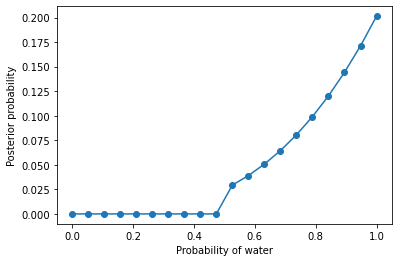

In [109]:
p_grid, posterior = posterior_grid_approximation(20, 3, 3)
plt.plot(p_grid, posterior, "C0o-")
plt.xlabel("Probability of water")
plt.ylabel("Posterior probability")

### Quadratic approximation

In [17]:
data = np.repeat((0,1), (3,6))
with pm.Model() as quad_approx_model:
    # prior
    p = pm.Uniform("p", 0, 1)
    # likelihood
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())
    # find posterior mode and std
    mean_q = pm.find_MAP()
    # find curvature at the mode of the posterior
    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

In [23]:
mean_q["p"]

array(0.66666667)

In [25]:
## Summary of quadratic approximation

print("Quadratic approximation returns a Gaussian distribution for the posterior with:\n\n"
      f"Mean {mean_q['p']:.2}\nStandard deviation {std_q[0]:.2}")

Quadratic approximation returns a Gaussian distribution for the posterior with:

Mean 0.67
Standard deviation 0.16


In [32]:
norm_dist = stats.norm(loc=mean_q["p"], scale=std_q[0])
# Define range of probability of interest
prob_range = 0.89
# Calculate quantiles associated to probability range
# ppf calculates the positions where the distribution acquires a certain cumulative probability
z = norm_dist.ppf([(1 - prob_range)/2, (1 + prob_range)/2]) 
print(f"Quantiles for 89% interval are:\n\n{z[0]:.2}, {z[1]:.2}")

Quantiles for 89% interval are:

0.42, 0.92


### MCMC

In [75]:
def run_mcmc(n_mcmc_samples, success, tosses):
    post_samples = np.zeros(n_mcmc_samples)
    post_samples[0] = 0.5
    like_samples = np.zeros_like(post_samples)
    like_samples[0] = stats.binom.pmf(success, n=tosses, p=post_samples[0])
    for i in range(1, n_mcmc_samples):
        p_test = np.random.normal(loc=post_samples[i-1], scale=0.1, size=1)
        
        if p_test < 0:
            p_test = -p_test
        elif p_test > 1:
            p_test = 2 - p_test
        
        like_test = stats.binom.pmf(success, n=tosses, p=p_test)

        if np.random.uniform(0, 1, 1) < like_test/like_samples[i-1]:
            post_samples[i] = p_test
            like_samples[i] = like_test
        else:
            post_samples[i] = post_samples[i-1]
            like_samples[i] = like_samples[i-1]
        
    return like_samples, post_samples

In [91]:
successes = 6
tosses = 9
likelihood, posterior = run_mcmc(1000, successes, tosses)

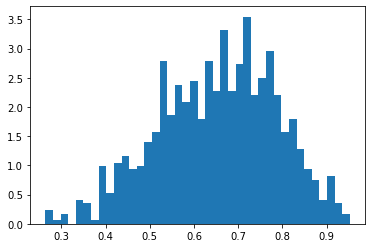

In [92]:
plt.hist(
    posterior,
    bins=40,
    density=True
);

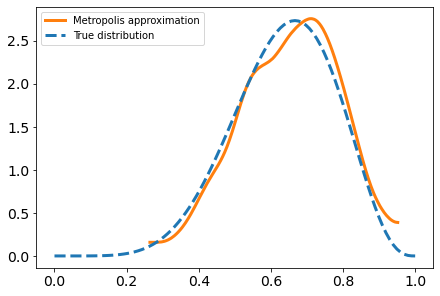

In [93]:
p_array = np.linspace(0, 1, 100)
az.plot_kde(posterior, 
            label="Metropolis approximation", 
            plot_kwargs={"color":"C1",
                         "linewidth":3
                        }
           )
plt.plot(p_array, 
         stats.beta.pdf(p_array, 
                        successes + 1,
                        tosses - successes + 1),
         "C0--",
         linewidth=3,
         label="True distribution",
        )
plt.legend()

### Exercises

In [115]:
# prior
prior = np.array([0.5, 0.5])
# likelihood
like = np.array([0.3, 1])
# posterior
unstd_posterior = like * prior
posterior = unstd_posterior/unstd_posterior.sum()
print(posterior)

[0.23076923 0.76923077]
